# Question 2: Diabetes Analysis using SDOH

In [44]:
!pip install imblearn

In [165]:
!pip install yellowbrick

In [171]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
%matplotlib inline

# Importing preprocessing and modeling libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import neighbors
from sklearn import tree
from sklearn.pipeline import Pipeline


# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


# # Importing class balance tools for handling imbalanced datasets
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from imblearn.over_sampling import SMOTE
from collections import Counter

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [46]:
# Setting the seed. Do not change.
seed = 10

## Part 1: Data Pre-processing

In [9]:
file_path = 'sdoh_FINAL.csv'
sdoh_data = pd.read_csv(file_path)

# Load the codebook
codebook_path = 'SDOH_2017_Codebook_County.xlsx'
sdoh_codebook = pd.read_excel(codebook_path)

# Display the first few rows of the dataset and the codebook
sdoh_codebook.head()

,Domain,SDOH Topic,Variable Name,Variable Label,Data Source,Type of Data (Numeric or Character),SAS Length,SAS Character,Position on the file
0,Identifier,NaN,YEAR,SDOH file year,NaN,num,4,4.,1
1,6. Geography,NaN,COUNTYFIPS,State-county FIPS Code (5-digit),NaN,char,5,$5.,2
2,6. Geography,NaN,STATEFIPS,State FIPS Code (2-digit),NaN,char,2,$2.,3
3,6. Geography,NaN,STATE,State name,NaN,char,25,$25.,4
4,6. Geography,NaN,COUNTY,County name,NaN,char,75,$75.,5


In [11]:
sdoh_data.head()

,YEAR,REGION,TERRITORY,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,...,POS_HOSP_PSYCH_RATE,POS_TOT_HOSP_AMBULANCE,POS_HOSP_AMBULANCE_RATE,POS_TOT_HOSP_CHEMO,POS_HOSP_CHEMO_RATE,POS_TOT_HOSP_ED,POS_HOSP_ED_RATE,POS_PCT_HOSP_FOR_PROFIT,POS_PCT_HOSP_NON_PROFIT,POS_PCT_HOSP_GOV
0,2017,South,0,55036.0,54293.0,51898.0,44109.0,42974.0,2746.0,36757.0,...,0.0,0.0,0.00,0.0,0.00,1.0,0.02,50.00,38.89,11.11
1,2017,South,0,203360.0,201089.0,191854.0,166364.0,163759.0,10031.0,143022.0,...,0.0,0.0,0.00,0.0,0.00,3.0,0.01,63.49,36.51,0.00
2,2017,South,0,26201.0,25925.0,24765.0,21627.0,21241.0,1071.0,18434.0,...,0.0,0.0,0.00,0.0,0.00,1.0,0.04,73.33,20.00,6.67
3,2017,South,0,22580.0,22224.0,21301.0,18743.0,18415.0,1137.0,15859.0,...,0.0,1.0,0.04,1.0,0.04,1.0,0.04,27.27,45.45,27.27
4,2017,South,0,57667.0,57088.0,54171.0,46501.0,45924.0,3224.0,39475.0,...,0.0,0.0,0.00,0.0,0.00,1.0,0.02,60.00,40.00,0.00


> The dataset contains 842 columns and 3226 entries with Null values handled earlier.

### Checking for Missing Values

In [15]:
# Check for missing values
missing_values = sdoh_data.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

- There are no missing values in the dataset. This is great because it simplifies our preprocessing steps, since we have dealt with data cleaning in another python notebook on our github repo.

### Standard Scaling and One hot encoding categorical variables

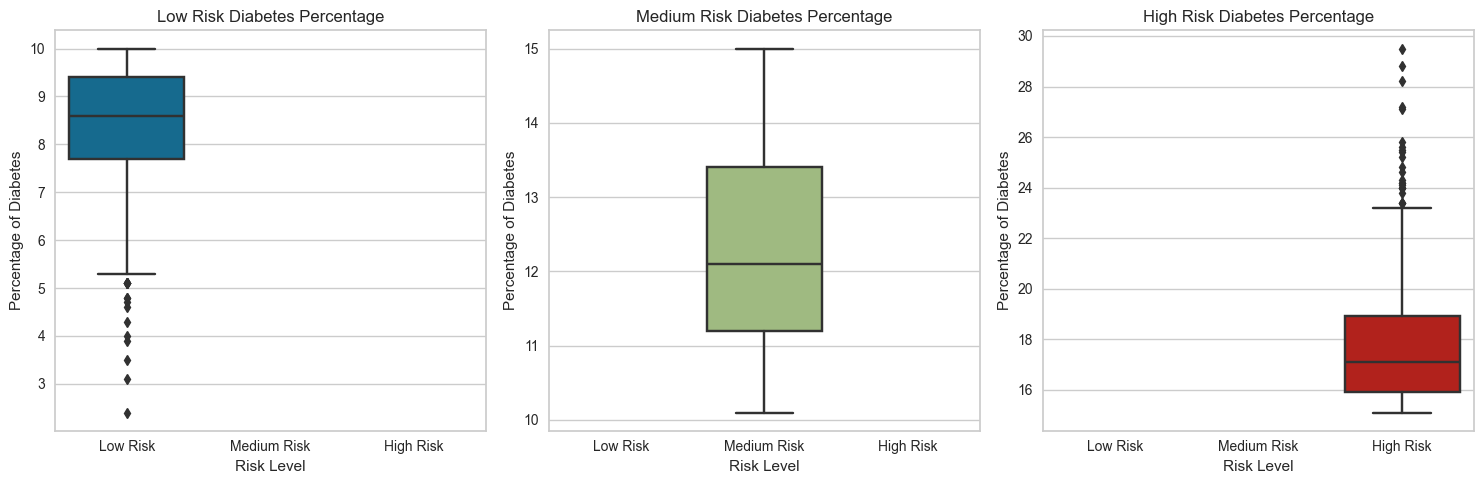

In [24]:
# Isolate the target variable and categorize it
sdoh_data['Risk_Level'] = pd.cut(sdoh_data['CHR_PCT_DIABETES'],
                                 bins=[-np.inf, 10, 15, np.inf],
                                 labels=['Low Risk', 'Medium Risk', 'High Risk'])

numeric_features = sdoh_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features.remove('YEAR')
numeric_features.remove('CHR_PCT_DIABETES')

categorical_features = ['REGION']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Transform data
sdoh_data_preprocessed = preprocessor.fit_transform(sdoh_data)

# Creating a DataFrame for visualization
column_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
df_scaled = pd.DataFrame(sdoh_data_preprocessed, columns=column_names)
df_scaled['Risk_Level'] = sdoh_data['Risk_Level']
df_scaled['CHR_PCT_DIABETES'] = sdoh_data['CHR_PCT_DIABETES']

# Suppressing FutureWarnings specifically from seaborn
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    # Plotting
    plt.figure(figsize=(15, 5))
    for i, risk_level in enumerate(['Low Risk', 'Medium Risk', 'High Risk'], 1):
        plt.subplot(1, 3, i)
        sns.boxplot(y='CHR_PCT_DIABETES', x='Risk_Level', data=df_scaled[df_scaled['Risk_Level'] == risk_level])
        plt.title(f'{risk_level} Diabetes Percentage')
        plt.ylabel('Percentage of Diabetes')
        plt.xlabel('Risk Level')

    plt.tight_layout()
    plt.show()

### Splitting the dataset into Train, Validation and Testing

In [27]:
X = sdoh_data.drop(['CHR_PCT_DIABETES', 'Risk_Level'], axis=1)
y = sdoh_data['Risk_Level']

# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)

### Using SMOTE

Class Distribution in Training Set:
Risk_Level
Medium Risk    0.506977
Low Risk       0.287209
High Risk      0.205814
Name: proportion, dtype: float64


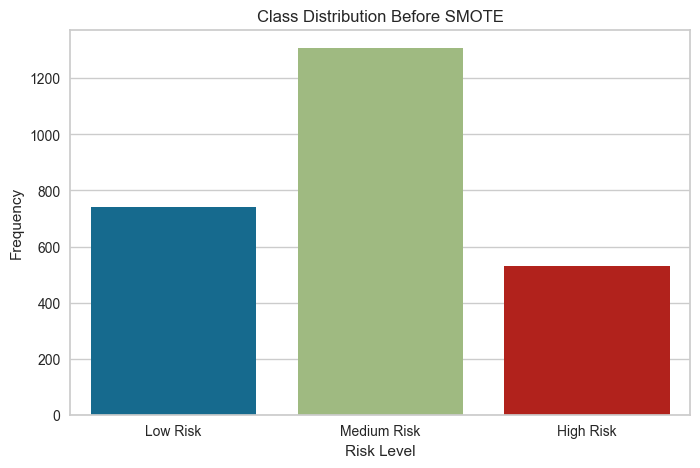

In [40]:
# Display the class distribution in the training dataset
class_distribution = y_train.value_counts(normalize=True)
print("Class Distribution in Training Set:")
print(class_distribution)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    # Plotting
    plt.figure(figsize=(8, 5))
    for i, risk_level in enumerate(['Low Risk', 'Medium Risk', 'High Risk'], 1):
        sns.countplot(x=y_train)
        plt.title('Class Distribution Before SMOTE')
        plt.ylabel('Frequency')
        plt.xlabel('Risk Level')
        
plt.show()

In [52]:
# Define preprocessing for numeric and categorical data
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = ['REGION']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline that includes SMOTE and the preprocessing
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=10))
])

# Apply transformations and SMOTE to the training data only
X_train_transformed, y_train_transformed = pipeline.fit_resample(X_train, y_train)

# Apply only transformations to the validation and test sets
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)


In [54]:
# Check the new class distribution
balanced_class_distribution = pd.Series(y_train_transformed).value_counts(normalize=True)
print(balanced_class_distribution)

Risk_Level
Low Risk       0.333333
Medium Risk    0.333333
High Risk      0.333333
Name: proportion, dtype: float64


<Figure size 800x600 with 0 Axes>

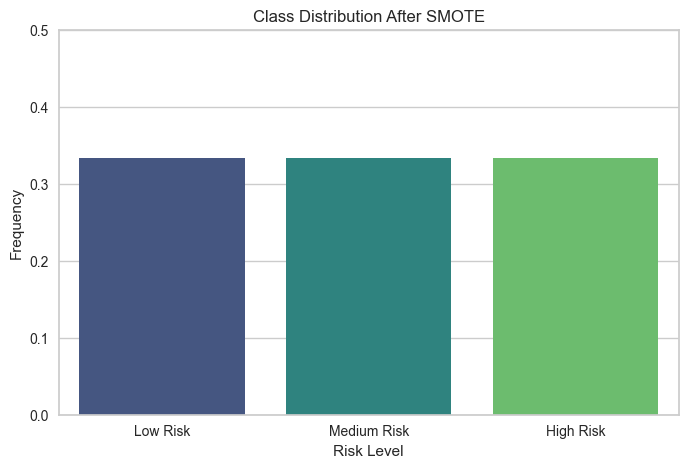

In [66]:
balanced_class_distribution = pd.Series(y_train_transformed).value_counts(normalize=True)

# Plotting the class distribution
plt.figure(figsize=(8, 6))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    # Plotting
    plt.figure(figsize=(8, 5))
    for i, risk_level in enumerate(['Low Risk', 'Medium Risk', 'High Risk'], 1):
        sns.barplot(x=balanced_class_distribution.index, y=balanced_class_distribution.values, palette='viridis')
        plt.title('Class Distribution After SMOTE')
        plt.ylabel('Frequency')
        plt.ylim(0, 0.5)
        plt.xlabel('Risk Level')
        
plt.show()

### Using PCA for Dimention Reduction

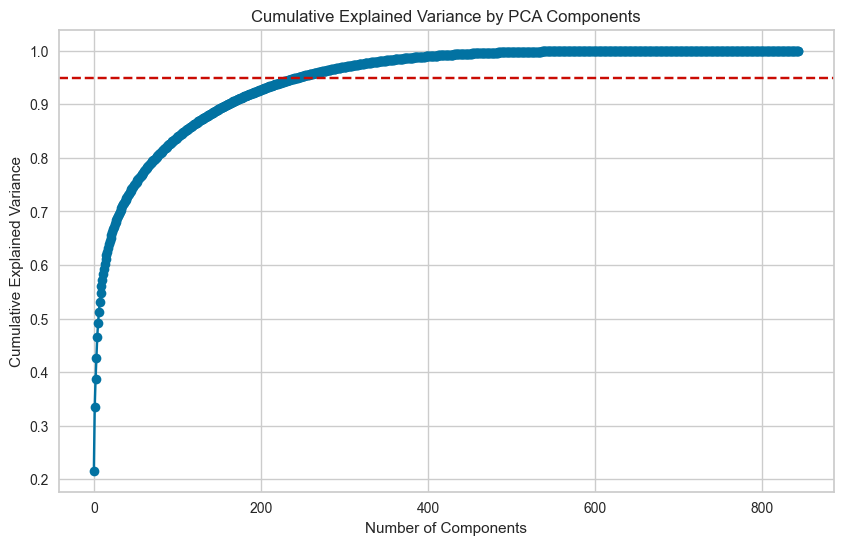

In [72]:
# Initialize PCA
pca = PCA(n_components=None)  # None to keep all components for variance analysis
X_train_pca = pca.fit_transform(X_train_transformed)

# Calculate cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # Line to show the 95% explained variance threshold
plt.show()

In [74]:
pca = PCA(n_components=150)

# Fit PCA on the training data and transform it
X_train_pca = pca.fit_transform(X_train_transformed)

# Transforming the validation and test data using the same PCA model
X_val_pca = pca.transform(X_val_transformed)
X_test_pca = pca.transform(X_test_transformed)

# Printing the shapes of the transformed data to confirm dimensionality reduction
print("Transformed training data shape:", X_train_pca.shape)
print("Transformed validation data shape:", X_val_pca.shape)
print("Transformed test data shape:", X_test_pca.shape)

Transformed training data shape: (3924, 150)
Transformed validation data shape: (323, 150)
Transformed test data shape: (323, 150)


## Logistic Regression

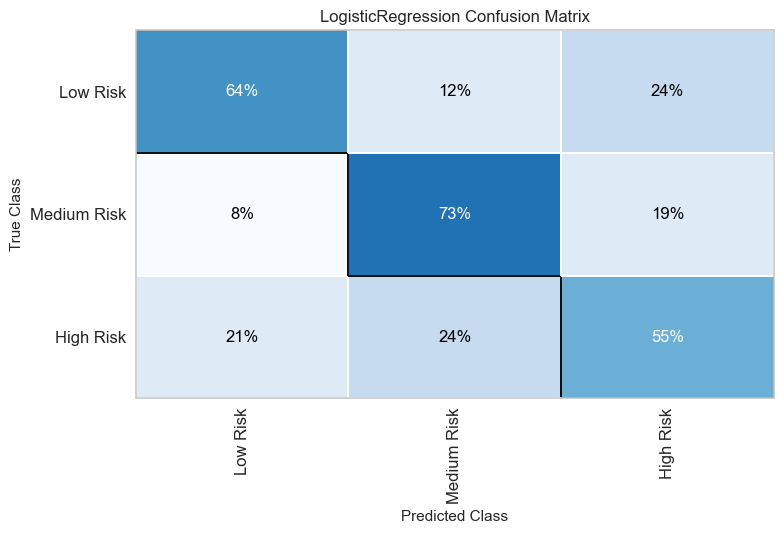


Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.51      0.64      0.57        67
    Low Risk       0.59      0.73      0.65        93
 Medium Risk       0.73      0.55      0.63       163

    accuracy                           0.62       323
   macro avg       0.61      0.64      0.62       323
weighted avg       0.64      0.62      0.62       323



In [183]:
# Initialize the Logistic Regression model with default settings for initial training
logistic_regression = LogisticRegression(random_state=10, max_iter=10000)

# Train the model on the PCA-transformed training data
logistic_regression.fit(X_train_pca, y_train_transformed)

# Predict on the PCA-transformed validation data
y_val_pred = logistic_regression.predict(X_val_pca)

# Evaluation metrics on the validation set
cm = ConfusionMatrix(
    logistic_regression,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val = classification_report(y_val, y_val_pred)


print("\nClassification Report on Validation Set:\n", class_report_val)

#### Hyperparameter Tuning LR

In [85]:
# Parameters to tune
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Types of penalties (L1 and L2)
    'solver': ['saga']  # Solver that supports L1 penalty
}

# Initialize the model with increased max_iter for stability
logistic_regression = LogisticRegression(random_state=10, max_iter=10000)

# Initialize GridSearchCV with training data
grid_search_lr = GridSearchCV(logistic_regression, param_grid_lr, cv=3, scoring='recall_macro', verbose=1)

# Fit GridSearchCV on the training data
grid_search_lr.fit(X_train_pca, y_train_transformed)

# Best parameters and best score
print("Best parameters:", grid_search_lr.best_params_)
print("Best recall (macro):", grid_search_lr.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best recall (macro): 0.692915392456677


#### Tuned LR model

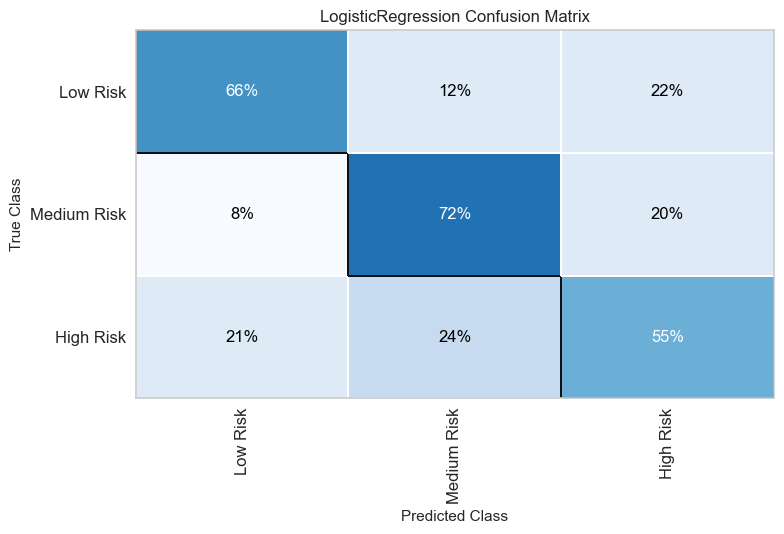


Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.52      0.66      0.58        67
    Low Risk       0.59      0.72      0.65        93
 Medium Risk       0.73      0.55      0.63       163

    accuracy                           0.62       323
   macro avg       0.61      0.64      0.62       323
weighted avg       0.64      0.62      0.62       323



In [181]:
# Initialize the Logistic Regression model with the best hyperparameters
logistic_regression_final = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=10000, random_state=10)

logistic_regression_final.fit(X_train_pca, y_train_transformed)

# Predict on the validation set
y_val_pred_final = logistic_regression_final.predict(X_val_pca)


cm = ConfusionMatrix(
    logistic_regression_final,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val_final = classification_report(y_val, y_val_pred_final)
print("\nClassification Report on Validation Set:\n", class_report_val_final)

## Random Forest Model

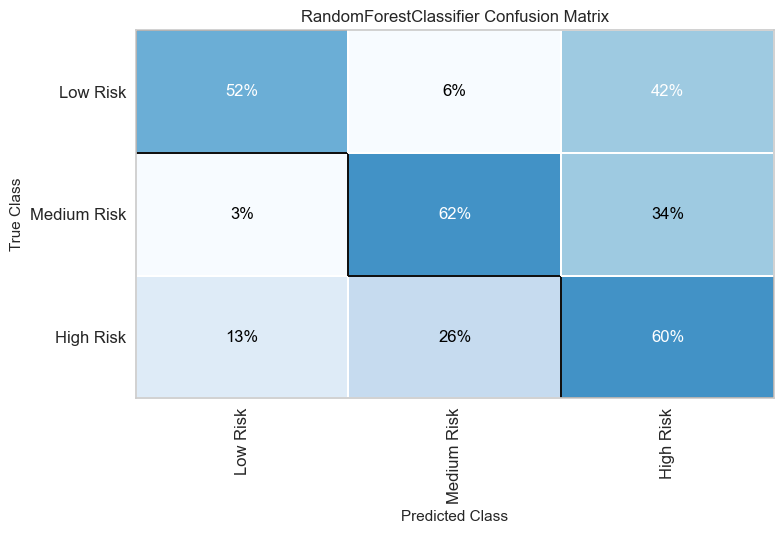


Random Forest - Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.58      0.52      0.55        67
    Low Risk       0.55      0.62      0.59        93
 Medium Risk       0.62      0.60      0.61       163

    accuracy                           0.59       323
   macro avg       0.59      0.58      0.58       323
weighted avg       0.59      0.59      0.59       323



In [185]:
# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=10)

# Train the model on the PCA-transformed and balanced training data
random_forest.fit(X_train_pca, y_train_transformed)

# Predict on the PCA-transformed validation data
y_val_pred_rf = random_forest.predict(X_val_pca)

# Evaluation metrics on the validation set
cm = ConfusionMatrix(
    random_forest,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val_rf = classification_report(y_val, y_val_pred_rf)

print("\nRandom Forest - Classification Report on Validation Set:\n", class_report_val_rf)

#### Hyperparameter Tuning with GridSearchCV for Random Forest

In [97]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the model with a higher n_jobs to speed up the use of multiple cores
random_forest = RandomForestClassifier(random_state=10, n_jobs=-1)

# Initialize GridSearchCV with training data
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=3, scoring='recall_macro', verbose=1)

# Fit GridSearchCV on the training data
grid_search_rf.fit(X_train_pca, y_train_transformed)

# Best parameters and best score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best recall (macro) for Random Forest:", grid_search_rf.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best recall (macro) for Random Forest: 0.7729357798165136


#### Fine-tuned Random Forest Model

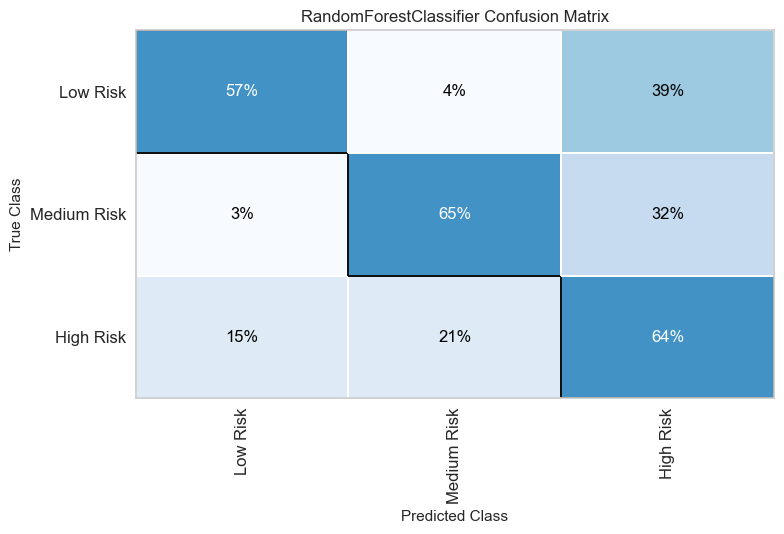


Final Random Forest - Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.58      0.57      0.58        67
    Low Risk       0.62      0.65      0.63        93
 Medium Risk       0.65      0.64      0.65       163

    accuracy                           0.63       323
   macro avg       0.62      0.62      0.62       323
weighted avg       0.63      0.63      0.63       323



In [187]:
# Initialize the model with the best parameters
random_forest_final = RandomForestClassifier(**grid_search_rf.best_params_, random_state=10)

# Train the model with the best parameters on the full training data
random_forest_final.fit(X_train_pca, y_train_transformed)

# Predict on the validation set
y_val_pred_final_rf = random_forest_final.predict(X_val_pca)

# Evaluate the final model on the validation set
# Evaluation metrics on the validation set
cm = ConfusionMatrix(
    random_forest_final,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()
class_report_val_final_rf = classification_report(y_val, y_val_pred_final_rf)

print("\nFinal Random Forest - Classification Report on Validation Set:\n", class_report_val_final_rf)

## AdaBoost Classifier

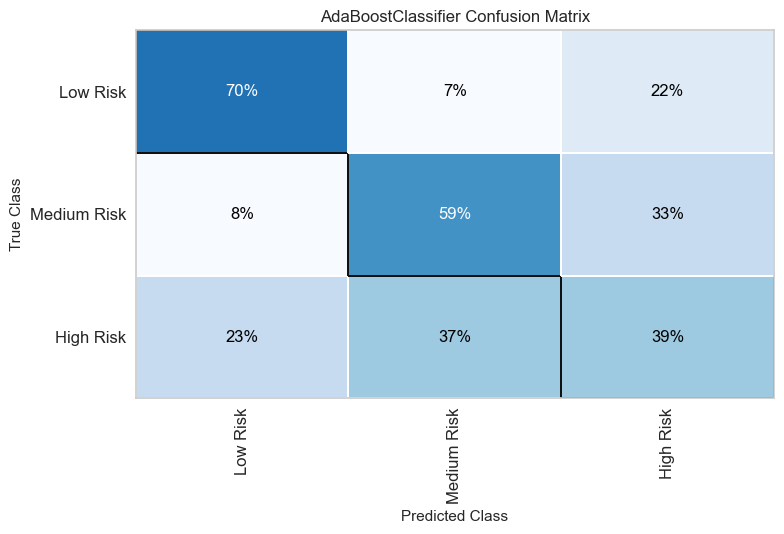


AdaBoost - Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.51      0.70      0.59        67
    Low Risk       0.45      0.59      0.51        93
 Medium Risk       0.58      0.39      0.47       163

    accuracy                           0.51       323
   macro avg       0.52      0.56      0.52       323
weighted avg       0.53      0.51      0.51       323



In [191]:
# Initialize the AdaBoost Classifier
adaboost = AdaBoostClassifier(random_state=10, algorithm='SAMME')

# Train the model on the PCA-transformed and balanced training data
adaboost.fit(X_train_pca, y_train_transformed)

# Predict on the PCA-transformed validation data
y_val_pred_ab = adaboost.predict(X_val_pca)

# Evaluation metrics on the validation set
cm = ConfusionMatrix(
    adaboost,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val_ab = classification_report(y_val, y_val_pred_ab)

print("\nAdaBoost - Classification Report on Validation Set:\n", class_report_val_ab)

#### Hyperparameter tuning AdaBoost Classifier Using GridsearchCV

In [113]:
# Parameters to tune
param_grid_ab = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages to perform
    'learning_rate': [0.01, 0.1, 1],  # Weight applied to each classifier at each boosting iteration
    'algorithm': ['SAMME']  # Using SAMME instead of SAMME.R to avoid deprecation warnings
}

# Initialize the AdaBoost model with SAMME algorithm
adaboost = AdaBoostClassifier(random_state=10, algorithm='SAMME')

# Initialize GridSearchCV with training data
grid_search_ab = GridSearchCV(adaboost, param_grid_ab, cv=3, scoring='recall_macro', verbose=1)

# Fit GridSearchCV on the training data
grid_search_ab.fit(X_train_pca, y_train_transformed)

# Best parameters and best score
print("Best parameters for AdaBoost:", grid_search_ab.best_params_)
print("Best recall (macro) for AdaBoost:", grid_search_ab.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 150}
Best recall (macro) for AdaBoost: 0.6299694189602447


#### Fine-tuned AdaBoost Classifier

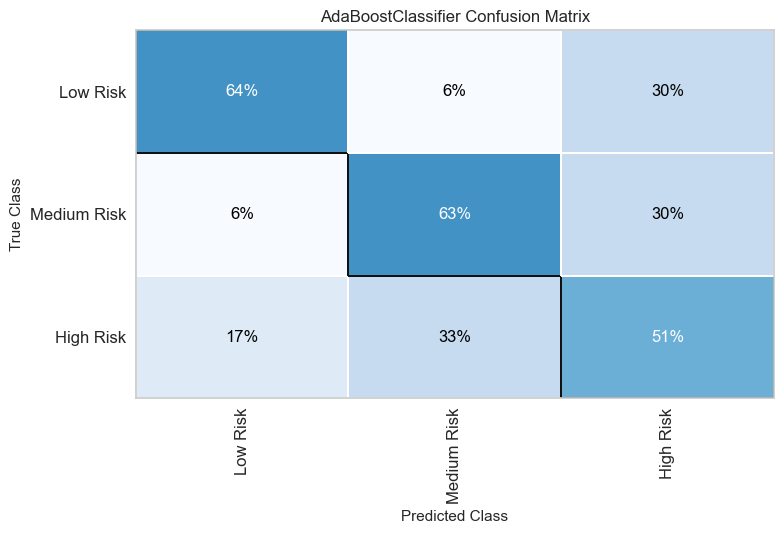


Final AdaBoost - Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.57      0.64      0.60        67
    Low Risk       0.51      0.63      0.56        93
 Medium Risk       0.63      0.51      0.56       163

    accuracy                           0.57       323
   macro avg       0.57      0.60      0.58       323
weighted avg       0.58      0.57      0.57       323



In [189]:
# Initialize the model with the best parameters found
adaboost_final = AdaBoostClassifier(**grid_search_ab.best_params_, random_state=10)

# Train the model with the best parameters on the full training data
adaboost_final.fit(X_train_pca, y_train_transformed)

# Predict on the validation set
y_val_pred_final_ab = adaboost_final.predict(X_val_pca)

# Evaluate the final model on the validation set
# Evaluation metrics on the validation set
cm = ConfusionMatrix(
    adaboost_final,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val_final_ab = classification_report(y_val, y_val_pred_final_ab)

print("\nFinal AdaBoost - Classification Report on Validation Set:\n", class_report_val_final_ab)

## XGBoost Classifier

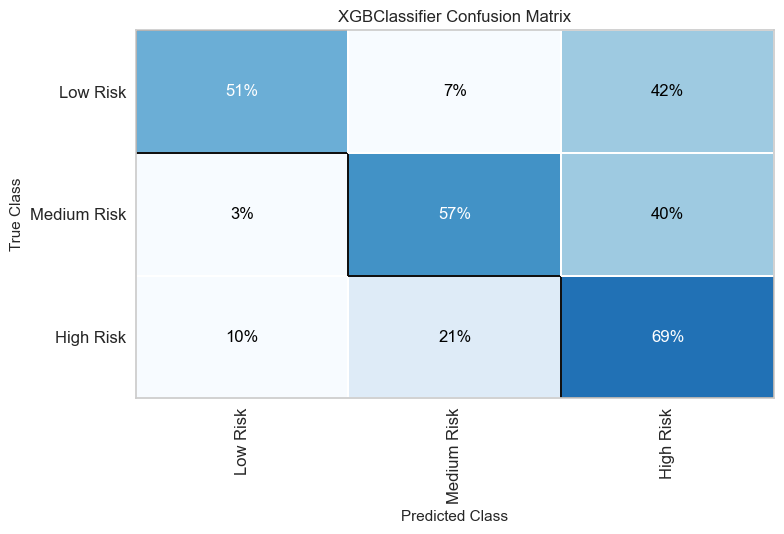


XGBoost - Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.63      0.51      0.56        67
    Low Risk       0.58      0.57      0.57        93
 Medium Risk       0.63      0.69      0.66       163

    accuracy                           0.62       323
   macro avg       0.61      0.59      0.60       323
weighted avg       0.62      0.62      0.61       323



In [193]:
# Encode class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_transformed)
y_val_encoded = label_encoder.transform(y_val)

# Initialize the XGBoost Classifier
xgboost = XGBClassifier(random_state=10, use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the PCA-transformed and class-encoded training data
xgboost.fit(X_train_pca, y_train_encoded)

# Predicting on the PCA-transformed and class-encoded validation data
y_val_pred_xgb = xgboost.predict(X_val_pca)

# Evaluation metrics on the validation set
cm = ConfusionMatrix(
    xgboost,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val_xgb = classification_report(y_val_encoded, y_val_pred_xgb, target_names=label_encoder.classes_)

print("\nXGBoost - Classification Report on Validation Set:\n", class_report_val_xgb)

#### Hyperparameter Tuning XGBoost Classifier

In [127]:
# Parameters for GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Initialize the XGBoost model
xgboost = XGBClassifier(random_state=10, use_label_encoder=False, eval_metric='mlogloss')

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(xgboost, param_grid_xgb, cv=3, scoring='recall_macro', verbose=1)

# Fit GridSearchCV on the training data
grid_search_xgb.fit(X_train_pca, y_train_encoded)

# Print the best parameters and best score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best recall (macro) for XGBoost:", grid_search_xgb.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Best recall (macro) for XGBoost: 0.7882262996941897


#### Fine-tuned XGBoost Classifier

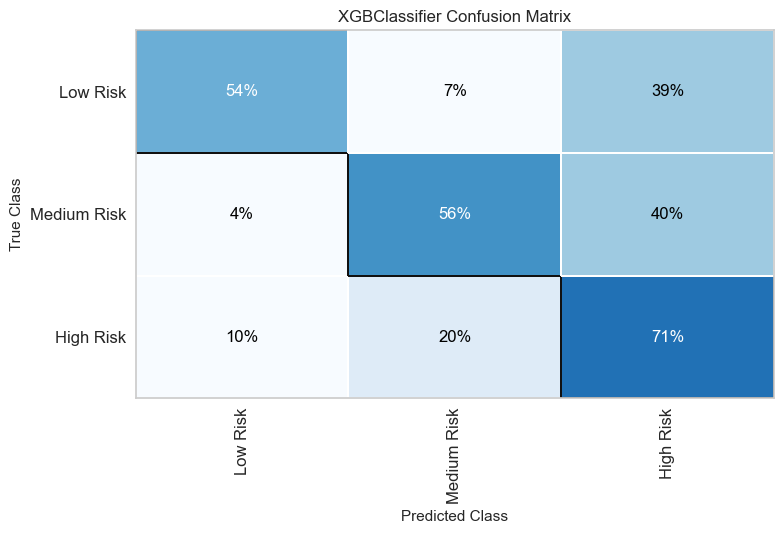


Final XGBoost - Classification Report on Validation Set:
               precision    recall  f1-score   support

   High Risk       0.64      0.54      0.59        67
    Low Risk       0.58      0.56      0.57        93
 Medium Risk       0.65      0.71      0.67       163

    accuracy                           0.63       323
   macro avg       0.62      0.60      0.61       323
weighted avg       0.63      0.63      0.63       323



In [195]:
# Initializing the model with the best parameters found
xgboost_final = XGBClassifier(**grid_search_xgb.best_params_, random_state=10, use_label_encoder=False, eval_metric='mlogloss')

# Train the model with the best parameters on the full training data
xgboost_final.fit(X_train_pca, y_train_encoded)

# Predict on the PCA-transformed and class-encoded validation data
y_val_encoded = label_encoder.transform(y_val)  # Ensure validation labels are encoded
y_val_pred_final_xgb = xgboost_final.predict(X_val_pca)

# Evaluate the final model on the validation set
cm = ConfusionMatrix(
    xgboost_final,
    classes=['Low Risk', 'Medium Risk', 'High Risk'],
    percent=True,
    cmap='Blues'  
)

# Fit to the training data, score it with the validation data
cm.fit(X_train_pca, y_train_transformed)
cm.score(X_val_pca, y_val)

# Show the confusion matrix
cm.show()

class_report_val_final_xgb = classification_report(y_val_encoded, y_val_pred_final_xgb, target_names=label_encoder.classes_)

print("\nFinal XGBoost - Classification Report on Validation Set:\n", class_report_val_final_xgb)

## Feature Importance Plots

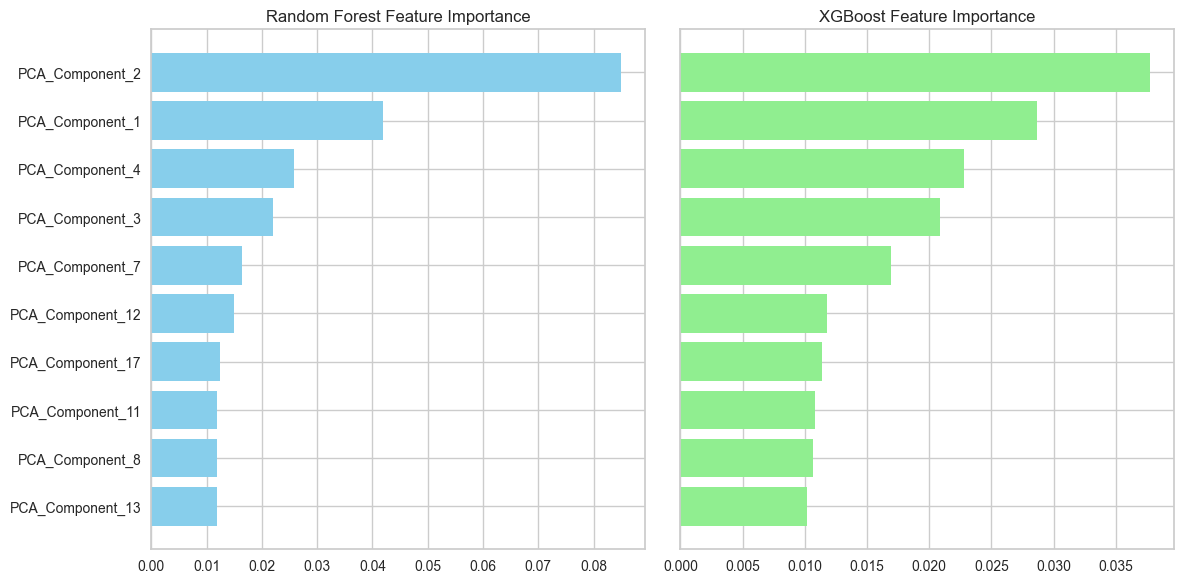

In [133]:
# Random Forest Feature Importance
rf_feature_importance = random_forest_final.feature_importances_
xgb_feature_importance = xgboost_final.feature_importances_

# Getting the indices of the top 10 features
rf_top10_idx = np.argsort(rf_feature_importance)[-10:]
xgb_top10_idx = np.argsort(xgb_feature_importance)[-10:]

# Creating feature names (assuming 150 PCA components)
features = [f'PCA_Component_{i}' for i in range(1, 151)]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

axes[0].barh(range(10), rf_feature_importance[rf_top10_idx], align='center', color='skyblue')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([features[i] for i in rf_top10_idx])
axes[0].set_title('Random Forest Feature Importance')

axes[1].barh(range(10), xgb_feature_importance[xgb_top10_idx], align='center', color='lightgreen')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([features[i] for i in xgb_top10_idx])
axes[1].set_title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

In [139]:
pca_components = pca.components_
feature_names = preprocessor.transformers_[0][-1]

In [141]:
def compute_original_feature_importances(pca_components, model_importances):
    # Each row in pca_components corresponds to one original feature
    # Each column in pca_components corresponds to one PCA component
    original_feature_importances = np.dot(pca_components.T, model_importances)
    return original_feature_importances

# Get model importances
rf_importances = random_forest_final.feature_importances_
xgb_importances = xgboost_final.feature_importances_

/var/folders/z6/83d71dz55636_z_tszz6pggw0000gn/T/ipykernel_7562/3136738362.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(np.array(feature_names)[top10_rf])
/var/folders/z6/83d71dz55636_z_tszz6pggw0000gn/T/ipykernel_7562/3136738362.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(np.array(feature_names)[top10_xgb])


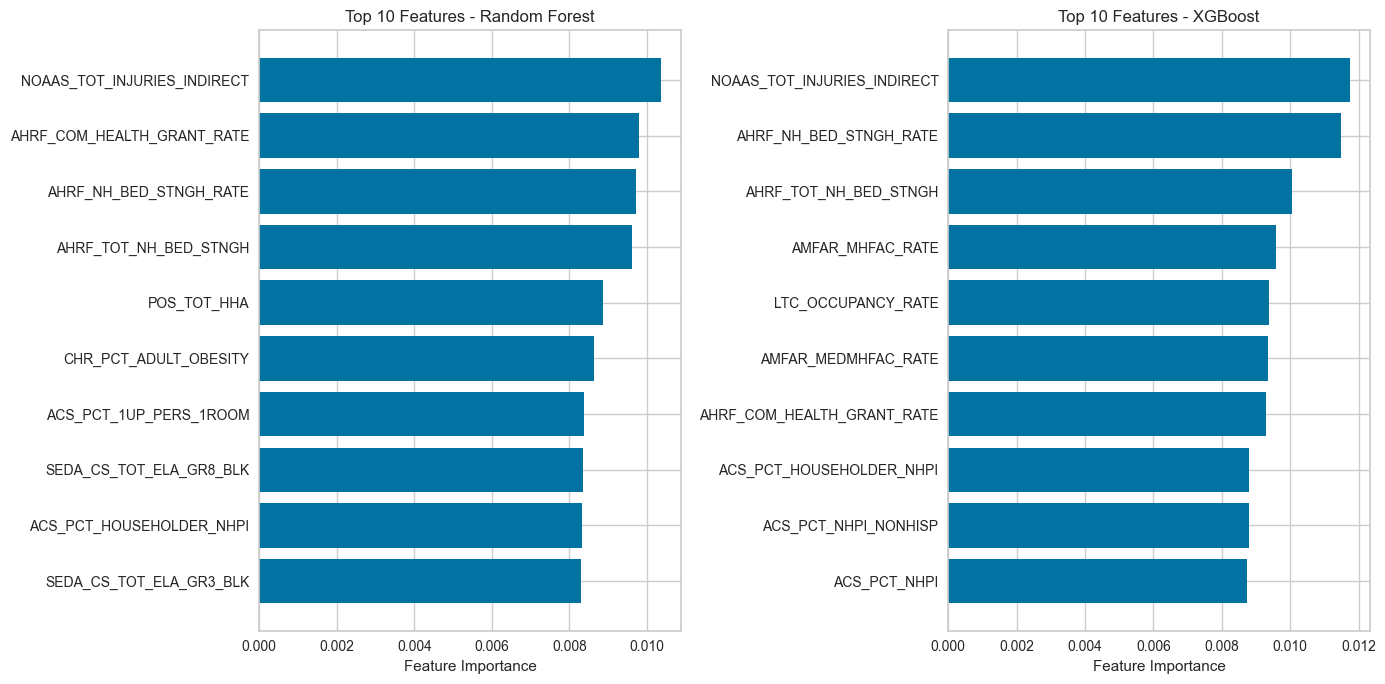

In [143]:
# Computing contributions for each model
rf_contributions = compute_original_feature_importances(pca_components, rf_importances)
xgb_contributions = compute_original_feature_importances(pca_components, xgb_importances)

# Identifying top 10 contributions
top10_rf = np.argsort(rf_contributions)[-10:]
top10_xgb = np.argsort(xgb_contributions)[-10:]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].barh(np.array(feature_names)[top10_rf], rf_contributions[top10_rf])
axs[0].set_title('Top 10 Features - Random Forest')
axs[0].set_xlabel('Feature Importance')
axs[0].set_yticklabels(np.array(feature_names)[top10_rf])

axs[1].barh(np.array(feature_names)[top10_xgb], xgb_contributions[top10_xgb])
axs[1].set_title('Top 10 Features - XGBoost')
axs[1].set_xlabel('Feature Importance')
axs[1].set_yticklabels(np.array(feature_names)[top10_xgb])

plt.tight_layout()
plt.show()

In [145]:
pca_components = pca.components_  # PCA components (loadings)

# AdaBoost feature importances
adaboost_importances = adaboost_final.feature_importances_

def compute_original_feature_importances(pca_components, model_importances):
    """Compute the contribution of original features based on PCA components and model importances."""
    original_feature_importances = np.dot(pca_components, model_importances)
    return np.abs(original_feature_importances)

# Calculate original feature importance for AdaBoost
original_feature_importances_ab = compute_original_feature_importances(pca_components.T, adaboost_importances)

# Sort the features based on importance
sorted_idx_ab = np.argsort(original_feature_importances_ab)[-10:]

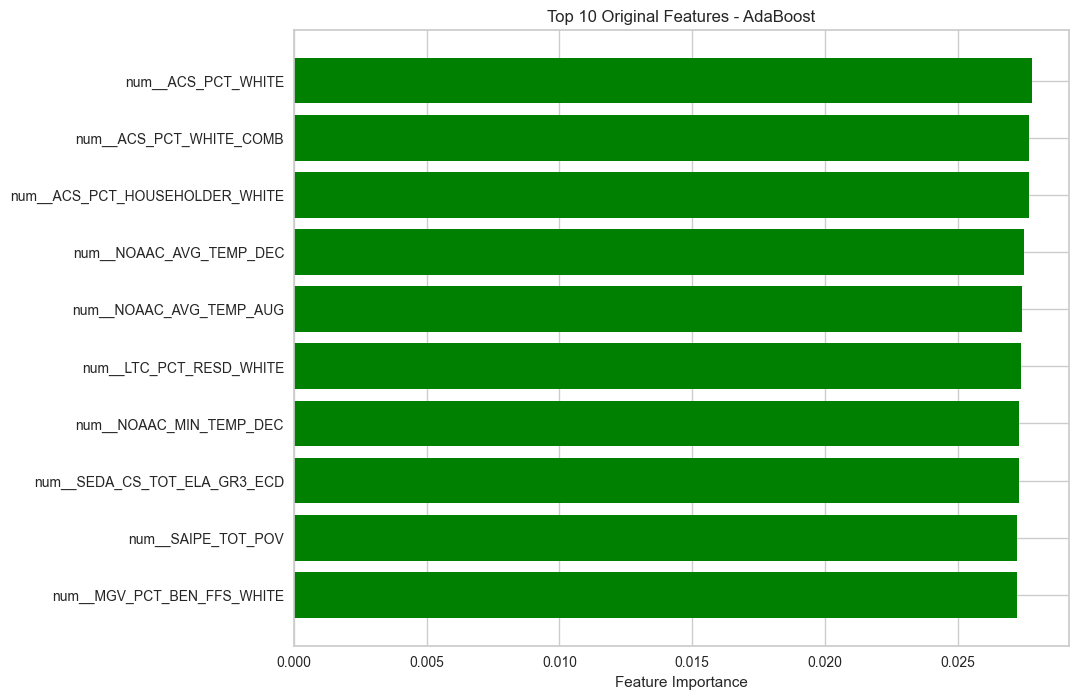

In [154]:
pca_components = pca.components_
adaboost_importances = adaboost_final.feature_importances_

# Calculate feature contributions
# Multiply the importance of each PCA component by each component's contribution to the original features
original_feature_importances = np.abs(pca_components.T @ adaboost_importances)

# Get the names of the original features (update this according to your actual feature names extraction)
feature_names = np.array(preprocessor.get_feature_names_out())

# Sort features by their importance scores
sorted_indices = np.argsort(original_feature_importances)[-10:]  # top 10 features

# Plotting the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_indices], original_feature_importances[sorted_indices], color='green')
plt.xlabel('Feature Importance')
plt.title('Top 10 Original Features - AdaBoost')
plt.show()

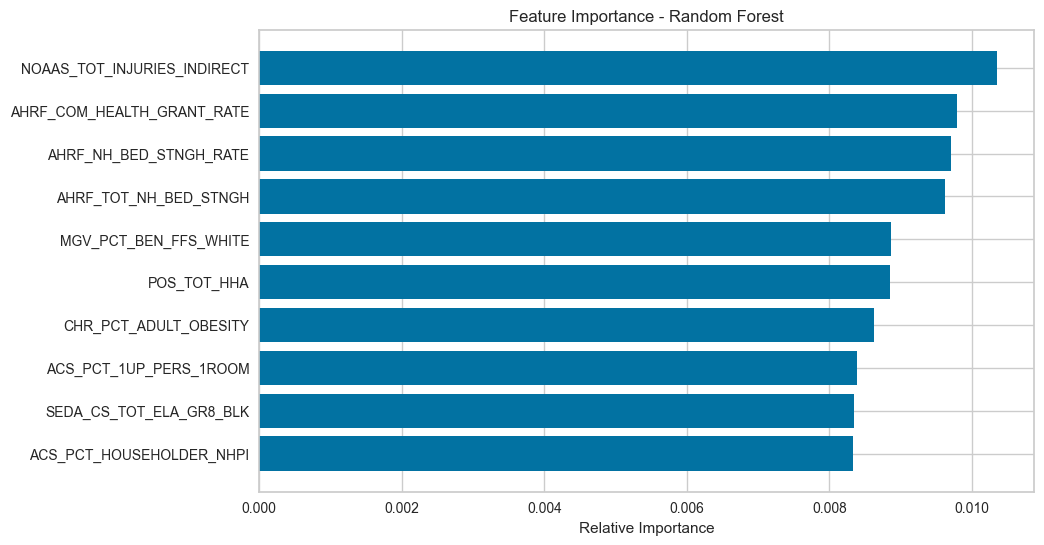

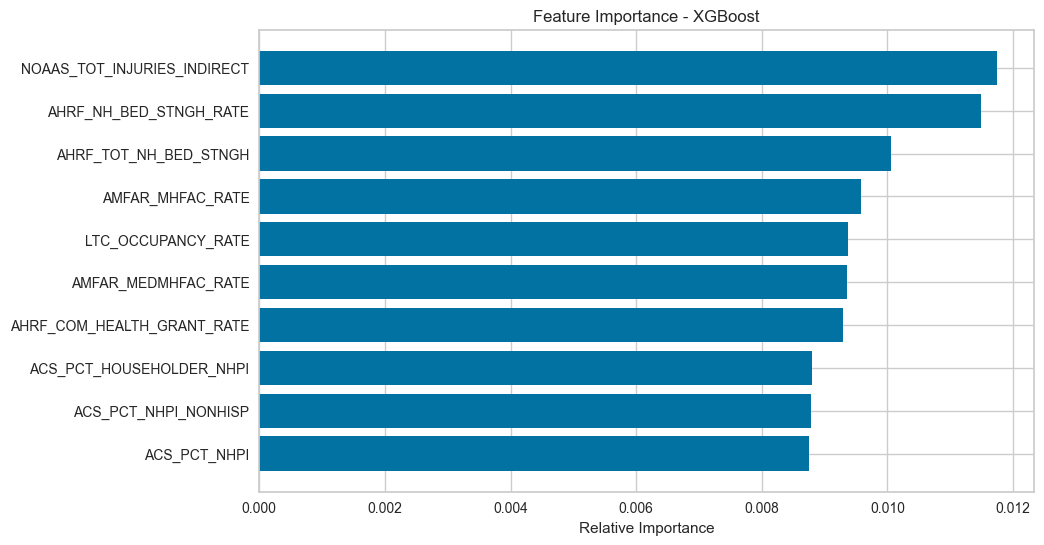

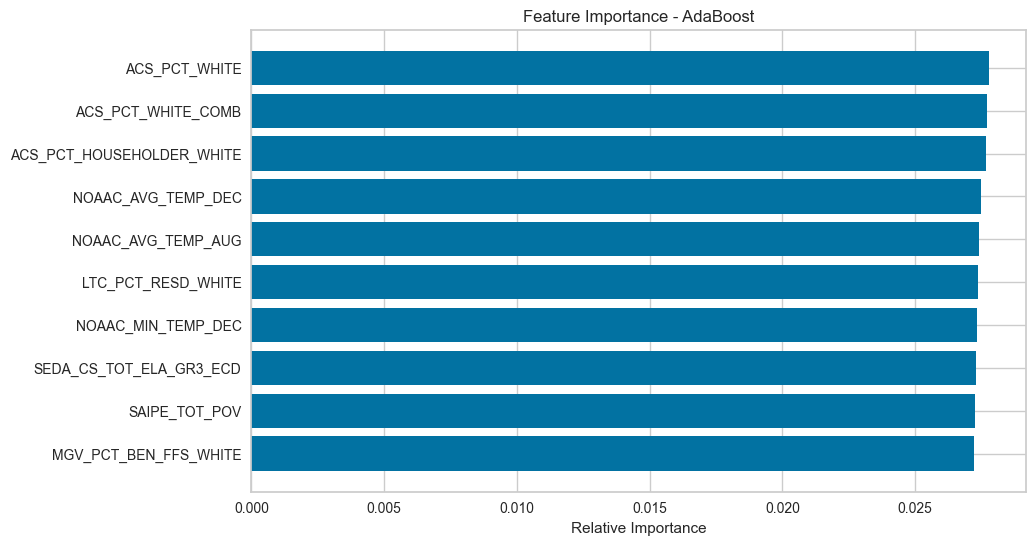

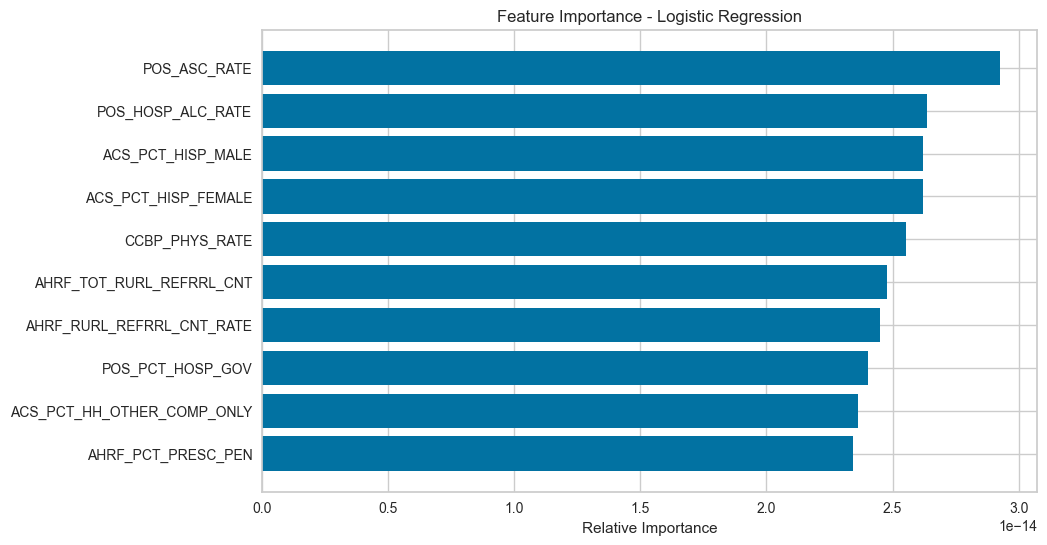

In [160]:
def plot_feature_importance(importances, feature_names, title):
    # Sort feature importances in descending order and select the top 10
    indices = np.argsort(importances)[-10:]
    features_sorted = feature_names[indices]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features_sorted)
    plt.xlabel('Relative Importance')
    plt.show()

average_lr_coefs = np.mean(logistic_regression_final.coef_, axis=0)
# Reverse the PCA to project the feature importance back onto the original features
original_importances_rf = np.abs(np.dot(pca.components_.T, random_forest_final.feature_importances_))
original_importances_xgb = np.abs(np.dot(pca.components_.T, xgboost_final.feature_importances_))
original_importances_ab = np.abs(np.dot(pca.components_.T, adaboost_final.feature_importances_))
# Logistic regression might not directly map back from PCA; this is illustrative
original_importances_lr = np.abs(np.dot(pca.components_.T, average_lr_coefs))

# Plotting for each model
plot_feature_importance(original_importances_rf, feature_names, "Feature Importance - Random Forest")
plot_feature_importance(original_importances_xgb, feature_names, "Feature Importance - XGBoost")
plot_feature_importance(original_importances_ab, feature_names, "Feature Importance - AdaBoost")
plot_feature_importance(original_importances_lr, feature_names, "Feature Importance - Logistic Regression")

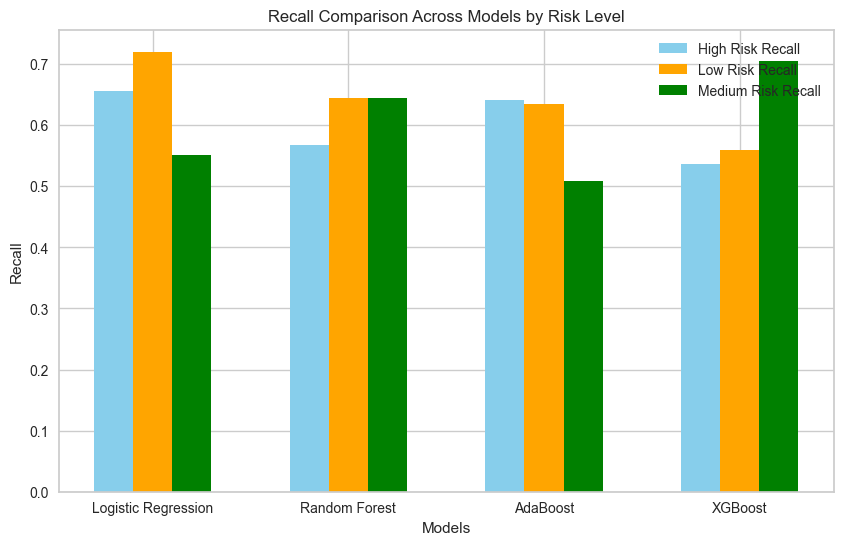

In [197]:
report_lr = classification_report(y_val, y_val_pred_final, output_dict=True)
report_rf = classification_report(y_val, y_val_pred_final_rf, output_dict=True)
report_ab = classification_report(y_val, y_val_pred_final_ab, output_dict=True)
report_xgb = classification_report(y_val_encoded, y_val_pred_final_xgb, output_dict=True, target_names=['High Risk', 'Low Risk', 'Medium Risk'])

# Function to extract recall values for "High Risk", "Low Risk", "Medium Risk"
def extract_recall(report):
    return [report['High Risk']['recall'], report['Low Risk']['recall'], report['Medium Risk']['recall']]

# Extract recalls for each model
recalls_lr = extract_recall(report_lr)
recalls_rf = extract_recall(report_rf)
recalls_ab = extract_recall(report_ab)
recalls_xgb = extract_recall(report_xgb)

# Data array for plotting
data = np.array([recalls_lr, recalls_rf, recalls_ab, recalls_xgb]).T

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
models = ['Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost']
colors = ['skyblue', 'orange', 'green', 'red']

for i, (recalls, color) in enumerate(zip(data, colors)):
    ax.bar(np.arange(len(models)) + i*bar_width, recalls, width=bar_width, label=f'{["High Risk", "Low Risk", "Medium Risk"][i]} Recall', color=color)

ax.set_xlabel('Models')
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison Across Models by Risk Level')
ax.set_xticks(np.arange(len(models)) + bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [199]:
from IPython.display import display

def extract_metrics(report):
    return {
        'High Risk Recall': report['High Risk']['recall'],
        'Low Risk Recall': report['Low Risk']['recall'],
        'Medium Risk Recall': report['Medium Risk']['recall'],
        'High Risk Precision': report['High Risk']['precision'],
        'Low Risk Precision': report['Low Risk']['precision'],
        'Medium Risk Precision': report['Medium Risk']['precision'],
        'High Risk F1-Score': report['High Risk']['f1-score'],
        'Low Risk F1-Score': report['Low Risk']['f1-score'],
        'Medium Risk F1-Score': report['Medium Risk']['f1-score'],
    }

# Create data for DataFrame
data = {
    'Logistic Regression': extract_metrics(report_lr),
    'Random Forest': extract_metrics(report_rf),
    'AdaBoost': extract_metrics(report_ab),
    'XGBoost': extract_metrics(report_xgb)
}

# Creating DataFrame
df = pd.DataFrame(data)

# Transposing DataFrame for better readability
df = df.T  # Transpose to have models as rows and metrics as columns

pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame wrapping

# Display the DataFrame
display(df)

,High Risk Recall,Low Risk Recall,Medium Risk Recall,High Risk Precision,Low Risk Precision,Medium Risk Precision,High Risk F1-Score,Low Risk F1-Score,Medium Risk F1-Score
Logistic Regression,0.657,0.720,0.552,0.518,0.588,0.726,0.579,0.647,0.627
Random Forest,0.567,0.645,0.644,0.585,0.619,0.652,0.576,0.632,0.648
AdaBoost,0.642,0.634,0.509,0.566,0.509,0.634,0.601,0.565,0.565
XGBoost,0.537,0.559,0.706,0.643,0.584,0.646,0.585,0.571,0.674
